In [1]:
!pip install torch-lr-finder;

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import transforms, models
from tqdm.notebook import tqdm
import random
from torch_lr_finder import LRFinder
import albumentations as A
from albumentations.pytorch import ToTensorV2

Set up data

In [3]:
import zipfile
with zipfile.ZipFile("/kaggle/input/facial-keypoints-detection/training.zip","r") as z:
    z.extractall(".")
with zipfile.ZipFile("/kaggle/input/facial-keypoints-detection/test.zip","r") as z:
    z.extractall(".")

In [4]:
trainDir = '/kaggle/working/training.csv'
testDir = '/kaggle/working/test.csv'
idLookupDir = '/kaggle/input/facial-keypoints-detection/IdLookupTable.csv'
trainData = pd.read_csv(trainDir)  
testData = pd.read_csv(testDir)
idLookupData = pd.read_csv(idLookupDir)

In [5]:
trainX = trainData['Image'].apply(lambda x: np.fromstring(x, dtype=np.uint8, sep=' '))
trainX = np.stack(trainX.to_numpy()).reshape(trainData['Image'].shape[0], 96, 96)

In [6]:
trainY = np.array(trainData.iloc[:, :-1])

Create Model

In [7]:
torch.manual_seed(0)
np.random.seed(0)

In [8]:
def plotImgNumpy(image, keypoints=None):
    plt.imshow(image, cmap='gray')
    if keypoints is not None:
        keypoints = keypoints.reshape(15,2)
        plt.plot(keypoints[:,0], keypoints[:,1], 'rx')

In [9]:
def plotImg(image, keypoints=None):
    image = image[0].numpy()
    plt.imshow(image, cmap='gray')
    if keypoints is not None:
        keypoints = keypoints.reshape(15,2)
        plt.plot(keypoints[:,0] * 95, keypoints[:,1] * 95, 'rx')

In [10]:
def masked_mse_loss(input, target):
    mask = ~torch.isnan(target)
    masked_input = input[mask]
    masked_target = target[mask]
    return F.mse_loss(masked_input, masked_target)
criterion = masked_mse_loss

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def getModel():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 30),
        nn.Sigmoid()
    )
    model = nn.Sequential(nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, bias=True), model)
    model.to(device, dtype=torch.float)
    return model

In [12]:
class TrainValDataset(Dataset):\
#     1 = Val, 2 = Full, 0 (or anything other than 1,2) = Train
    def __init__(self, trainX, trainY, transform=None, train=0, split_ratio=.8):
        self.transform = transform
        np.random.seed(0)
        indices = np.random.permutation(trainX.shape[0])
        if train == 2:
            self.data = trainX
            self.target = trainY
        elif train == 1:
            self.data = trainX[indices][int(split_ratio * trainX.shape[0]):]
            self.target = trainY[indices][int(split_ratio * trainX.shape[0]):]
        else:
            self.data = trainX[indices][:int(split_ratio * trainX.shape[0])]
            self.target = trainY[indices][:int(split_ratio * trainX.shape[0])]
            
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.target[idx].reshape(15,2)
        if self.transform:
            transformed = self.transform(image=x, keypoints=y)
            x, y = transformed['image'], transformed['keypoints']
        return torch.tensor(x[None,:,:]).float(), torch.tensor(y).reshape(30,).float() / 95.0

In [13]:
transform = A.Compose([
    A.GaussNoise(),
    A.PixelDropout(),
    A.RandomBrightnessContrast(),
    A.CropAndPad(percent=[-.2,0]),
    A.Affine(scale=[.9,1.1], translate_percent=[-.1,.1], rotate=[-45, 45], shear=[-30, 30])
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

In [14]:
train_data = TrainValDataset(trainX, trainY, transform)
val_data = TrainValDataset(trainX, trainY, train=1)
test_data = TrainValDataset(trainX, trainY, transform, train=2)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

loader = DataLoader(test_data, batch_size=64, shuffle=True)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.15E-02


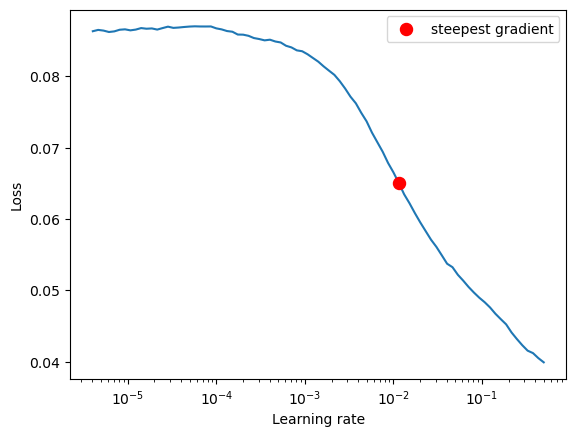

In [15]:
model = getModel()
optimizer = optim.SGD(model.parameters(), lr=1e-6, momentum=.9)
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(train_loader, end_lr=1, num_iter=100)
lr_finder.plot()
lr_finder.reset()

  0%|          | 0/89 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 11.716503 Val Loss: 4.556534


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 6.334746 Val Loss: 3.505411


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 5.219077 Val Loss: 3.174176


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 4.635708 Val Loss: 2.795754


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 4.564211 Val Loss: 2.829526


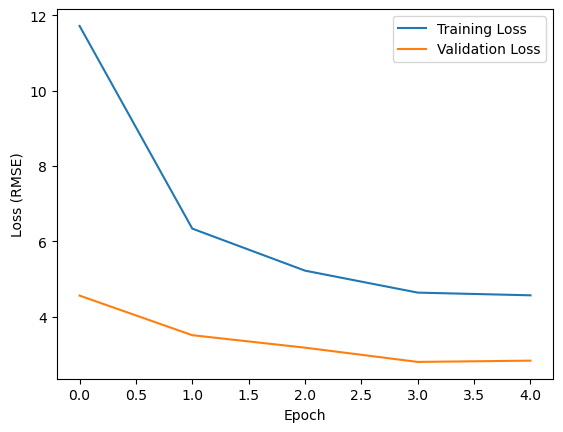

In [16]:
# Validate method to see how good it will be
model = getModel()
best_model = [copy.deepcopy(model), -1, 100, 100] # (model, epoch, train loss, val loss)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
train_loss_history = []
val_loss_history = []
for epoch in range(5):
    train_loss = 0
    val_loss = 0
    model.train()
    progress = tqdm(train_loader)
    for data, target in progress:
        data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        progress.set_postfix({'Loss': loss.item()})

    model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_loss = 95 * (train_loss **.5)
    val_loss = 95 * (val_loss **.5)
    
    if val_loss < best_model[3]:
        best_model = [copy.deepcopy(model), epoch + 1, train_loss, val_loss]

    print('Epoch: {} Train Loss: {:.6f} Val Loss: {:.6f}'.format(
        epoch+1, train_loss, val_loss))
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (RMSE)')
plt.legend()
plt.show()

In [17]:
best_model[1:]

[4, 4.635708346709792, 2.795753784164373]

In [18]:
m = best_model[0].eval()

In [19]:
t_data = TrainValDataset(trainX, trainY, train=2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


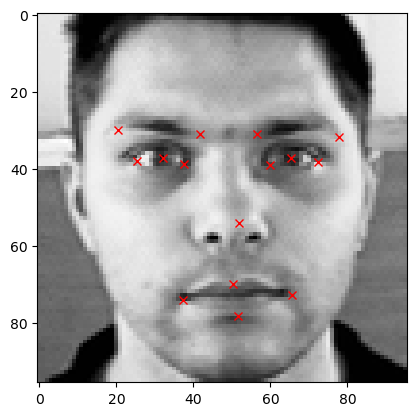

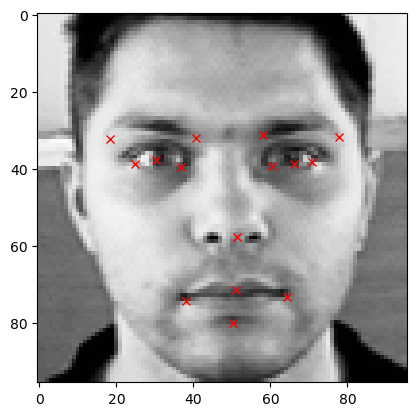

In [20]:
x, y = t_data.__getitem__(3)
yPred = m(torch.tensor(x[None,:,:]).float().to(device)).cpu().detach()[0]
plotImg(x,y)
plt.show()
plotImg(x,yPred)
plt.show()

In [21]:
testX = testData['Image'].apply(lambda x: np.fromstring(x, dtype=np.uint8, sep=' '))
testX = np.stack(testX.to_numpy()).reshape(testData['Image'].shape[0], 96, 96)

In [22]:
model = best_model[0].eval()
testX = torch.from_numpy(testX[:,np.newaxis,np.newaxis,:,:]).float().to(device, dtype=torch.float)
testPred = []
for i in range(len(testX)):
    testPred.append(np.squeeze(model(testX[i]).cpu().detach().numpy()) * 95)

Create submission

In [23]:
featureNameIndicesMap = {}
for i, feature in enumerate(trainData.T.index[:-1]):
    featureNameIndicesMap[feature] = i
featureNameIndicesMap

{'left_eye_center_x': 0,
 'left_eye_center_y': 1,
 'right_eye_center_x': 2,
 'right_eye_center_y': 3,
 'left_eye_inner_corner_x': 4,
 'left_eye_inner_corner_y': 5,
 'left_eye_outer_corner_x': 6,
 'left_eye_outer_corner_y': 7,
 'right_eye_inner_corner_x': 8,
 'right_eye_inner_corner_y': 9,
 'right_eye_outer_corner_x': 10,
 'right_eye_outer_corner_y': 11,
 'left_eyebrow_inner_end_x': 12,
 'left_eyebrow_inner_end_y': 13,
 'left_eyebrow_outer_end_x': 14,
 'left_eyebrow_outer_end_y': 15,
 'right_eyebrow_inner_end_x': 16,
 'right_eyebrow_inner_end_y': 17,
 'right_eyebrow_outer_end_x': 18,
 'right_eyebrow_outer_end_y': 19,
 'nose_tip_x': 20,
 'nose_tip_y': 21,
 'mouth_left_corner_x': 22,
 'mouth_left_corner_y': 23,
 'mouth_right_corner_x': 24,
 'mouth_right_corner_y': 25,
 'mouth_center_top_lip_x': 26,
 'mouth_center_top_lip_y': 27,
 'mouth_center_bottom_lip_x': 28,
 'mouth_center_bottom_lip_y': 29}

In [24]:
for i in range(len(idLookupData)):
    idLookupData['Location'][i] = testPred[idLookupData['ImageId'][i] - 1][featureNameIndicesMap[idLookupData['FeatureName'][i]]]
idLookupData.iloc[[0,1,2,30,31,32],:]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,66.365562
1,2,1,left_eye_center_y,37.198826
2,3,1,right_eye_center_x,28.802938
30,31,2,left_eye_center_x,64.772804
31,32,2,left_eye_center_y,36.935333
32,33,2,right_eye_center_x,28.853893


In [25]:
submission = idLookupData[['RowId', 'Location']]
submission.to_csv('submission.csv', index=False)